In [ ]:
# Check for GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# Get the data
!wget https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_single.csv

--2022-04-27 02:32:37--  https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_single.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50004 (49K) [text/plain]
Saving to: ‘daily_single.csv’

daily_single.csv    100%[===================>]  48.83K  --.-KB/s    in 0.007s  

2022-04-27 02:32:37 (6.51 MB/s) - ‘daily_single.csv’ saved [50004/50004]



In [ ]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/daily_single.csv", parse_dates=["Timestamp"])
df.rename(columns = {"Daily_Close": "Price"}, inplace = True)
df['Timestamp'] = df['Timestamp'].dt.date
btc_df = df.set_index('Timestamp')
btc_df.head(), btc_df.tail()

(             Price
 Timestamp         
 2014-01-01  754.90
 2014-01-02  784.19
 2014-01-03  809.40
 2014-01-04  828.79
 2014-01-05  905.00,                Price
 Timestamp           
 2021-03-26  52734.30
 2021-03-27  54508.16
 2021-03-28  55871.93
 2021-03-29  57788.15
 2021-03-30  59069.29)

In [ ]:
len(btc_df)

2236

In [ ]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2236 entries, 2014-01-01 to 2021-03-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2236 non-null   float64
dtypes: float64(1)
memory usage: 34.9+ KB


In [ ]:
btc_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,2236.0,6692.873421,9291.712386,191.0,588.5375,4563.135,9107.615,60095.59


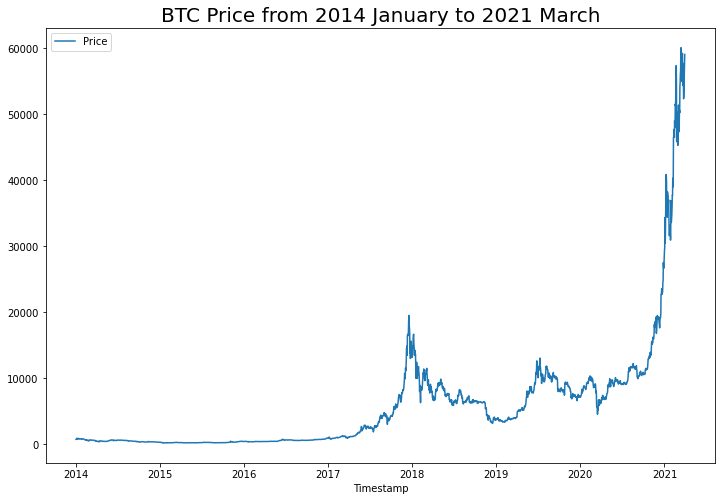

In [ ]:
import matplotlib.pyplot as plt
btc_df.plot(figsize = (12,8))
plt.title("BTC Price from 2014 January to 2021 March", fontsize=20);
# ';' is put at last to remove unnecessary text from being displayed

In [ ]:
btc_df.index.to_numpy()

array([datetime.date(2014, 1, 1), datetime.date(2014, 1, 2),
       datetime.date(2014, 1, 3), ..., datetime.date(2021, 3, 28),
       datetime.date(2021, 3, 29), datetime.date(2021, 3, 30)],
      dtype=object)

In [ ]:
# Makes arrays for each feature
timesteps = btc_df.index.to_numpy()
prices = btc_df["Price"].to_numpy()
boundary = int(0.8 * len(prices)) # 80% train, 20% test
X_train, y_train = timesteps[:boundary], prices[:boundary]
X_test, y_test = timesteps[boundary:], prices[boundary:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1788, 448, 1788, 448)

In [ ]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None, xlabel='Timestamp', ylabel='Price'): 
  # for format, we can go with '.' or '-' [scatter or line] and start means offset
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

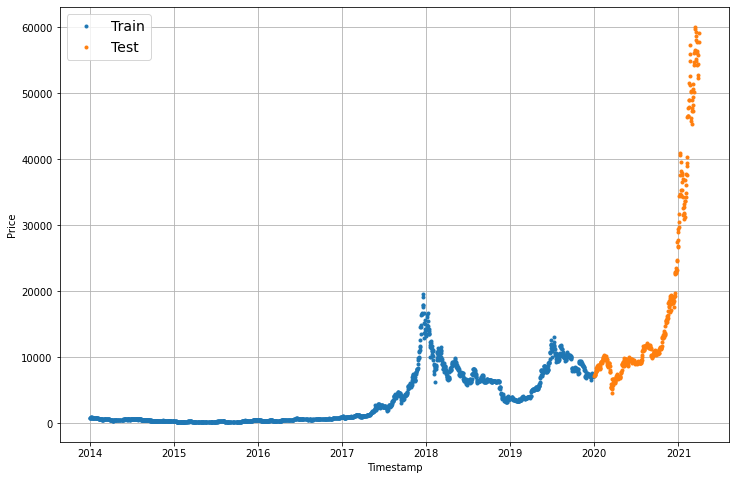

In [ ]:
plt.figure(figsize=(12,8)) # Creates a figure and adds the following plot to it
plot_time_series(X_train, y_train, label= "Train")
plot_time_series(X_test, y_test, label = "Test")
# It would be interesting to put start and end as the year

In [ ]:
# a = [1,2,3,4]
# a, a[:-1]

Naive baseline model:
$\hat{y}_{t} = y_{t-1}$

In [ ]:
naive_forecast = y_test[:-1] # Gets every value excluding the last value
# naive_forecast[-10:] != y_test[-10:]

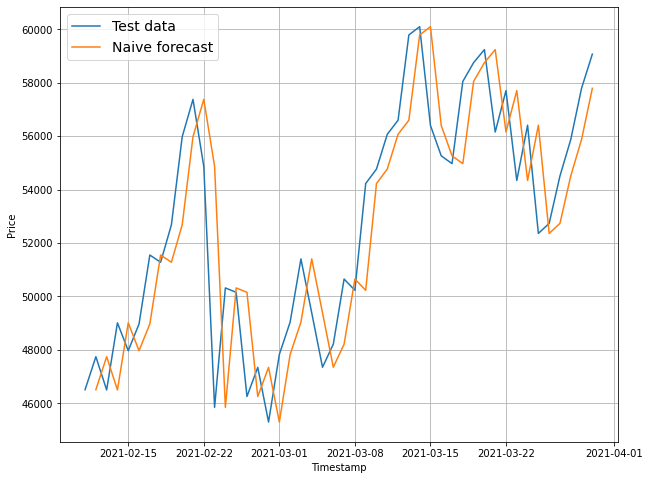

In [ ]:
# Comparing naive_forecast with the test data
plt.figure(figsize=(10, 8))
offset = 400
plot_time_series(timesteps=X_test, values=y_test, start = 400, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start = 400, format="-", label="Naive forecast");

In [ ]:
# Let's get TensorFlow! 
import tensorflow as tf

In [ ]:
def mase_(y_true, y_pred):
  # Assuming no seasonality and our crypto price data has no seasonality
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:], naive_forecast)) # naive_forecast = y_true[:-1]
  return mae/mae_naive

In [ ]:
# mase(y_true=y_test[1:], y_pred= naive_forecast).numpy() #should be close to 1

In [ ]:
# type(y_test[0]),y_test[0].dtype
# Numpy is float64 datatype as default so we need to convert to float32 datatype while using tensorflow

In [ ]:
# returns error metrics in dictionary form:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # better to use the numpy version of these too
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mase_(y_true, y_pred)
  
  return_dict =  {
                  "mae": mae.numpy(),
                  "mse": mse.numpy(),
                  "rmse": rmse.numpy(),
                  "mape": mape.numpy(),
                  "mase": mase.numpy()
                  }
  return return_dict

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 571.1008,
 'mape': 2.703912,
 'mase': 0.99867785,
 'mse': 1341613.9,
 'rmse': 1158.2805}

In [ ]:
tf.reduce_mean(y_test).numpy()

17809.185937500002

In [ ]:
# Windowing dataset to turn our data into supervised learning problem by giving labels
# Global variables are usually put with capital letters
# Using previous 7 days data to predict the price of 1 day
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# a=[1,2,3,4,5]
# a[:, :-1]
a = tf.expand_dims(tf.range(8)+1, axis=0)[:, :-1]
print(a)
tf.squeeze(a).numpy()

tf.Tensor([[1 2 3 4 5 6 7]], shape=(1, 7), dtype=int32)


array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We need to do the above on our entire btc data. For doing it, using python for loops is good but it becomes very slow when using it in python for-loops so we are using numpy index.

In [ ]:
# make windows from numpy arrays
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    returns 2D array of sequential windows of window size
    """
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T # -1 to prevent window going off the last value

    # Here window_indexes gives the position of the value of respective indexes, so using x[window_indexes] puts the respective x values in the position
    # specified in the windoe_indexes. It only works with numpy arrays
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=HORIZON)
    return windows, labels

    # a = np.array([1,2,3,4])
    # x = np.array([10,11,12,13,14])
    # a, x, x[a]

In [ ]:
# Passing the whole dataset in the windows
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(2229, 2229)

In [ ]:
def make_train_test_splits(windows, labels, test_split = 0.2):
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  # returns in the same order as skit-learn splitting function returns
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Create a train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
len(train_labels[:-HORIZON]), len(train_labels), len(train_labels[:-HORIZON-1]), len(y_train), len(y_train[WINDOW_SIZE:])

(1782, 1783, 1781, 1788, 1781)

In [ ]:
train_labels[:5], tf.squeeze(train_labels[:5]).numpy()

(array([[824.76],
        [852.61],
        [896.59],
        [844.05],
        [823.  ]]), array([824.76, 852.61, 896.59, 844.05, 823.  ]))

In [ ]:
# len(tf.keras.preprocessing.timeseries_dataset_from_array(data =prices, targets = None, sequence_length=7, sampling_rate=1, sequence_stride=1, shuffle=False))

In [ ]:
# Make the train/test splits
# Our approach is to window the data first and then make tests/train splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1783, 446, 1783, 446)

In [ ]:
train_windows

array([[ 754.9 ,  784.19,  809.4 , ...,  905.  ,  919.24,  785.  ],
       [ 784.19,  809.4 ,  828.79, ...,  919.24,  785.  ,  824.76],
       [ 809.4 ,  828.79,  905.  , ...,  785.  ,  824.76,  852.61],
       ...,
       [7208.69, 7181.73, 7133.65, ..., 7326.  , 7298.62, 7222.11],
       [7181.73, 7133.65, 7284.59, ..., 7298.62, 7222.11, 7171.68],
       [7133.65, 7284.59, 7326.  , ..., 7222.11, 7171.68, 7129.2 ]])

In [ ]:
# os is imported to save the model's best performance in google colab
import os
"""
  Since we are comparing different model's performance, it is better to compare each model's best performance with another model's best
  Model's performance is going to fluctuate epoch to epoch
  Create a function to implement a ModelCheckpoint callback with a specific filename 
"""

def create_model_checkpoint(model_name, save_path="models"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0, # elsewise continously printout if saved or not
                                            save_best_only=True)

In [ ]:
""" 
  Model-1: Dense model (window=7, horizon=1)
  The values are chosen by doing experiments
"""

import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reprodicible results as possible
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation='relu'),
  layers.Dense(HORIZON, activation='linear') # Same output as it was passed into it (similar to no activation)
], name='model_1_dense') # we can use it for our checkpoint function

# 2. Compile
model_1.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1, # it refers to how much information we want to print for our models
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # saves the best model



Epoch 1/100
14/14 [==============================] - 2s 75ms/step - loss: 1101.4742 - mae: 1101.4742 - mse: 3686015.2500 - val_loss: 1823.4686 - val_mae: 1823.4686 - val_mse: 7446906.5000
Epoch 2/100
14/14 [==============================] - 1s 59ms/step - loss: 364.8518 - mae: 364.8518 - mse: 455562.6562 - val_loss: 1636.2445 - val_mae: 1636.2445 - val_mse: 6570923.0000
Epoch 3/100
14/14 [==============================] - 1s 57ms/step - loss: 262.0773 - mae: 262.0773 - mse: 276249.4062 - val_loss: 910.5252 - val_mae: 910.5252 - val_mse: 2657822.5000
Epoch 4/100
14/14 [==============================] - 1s 59ms/step - loss: 229.8440 - mae: 229.8440 - mse: 223030.8281 - val_loss: 871.9905 - val_mae: 871.9905 - val_mse: 2471795.2500
Epoch 5/100
14/14 [==============================] - 0s 13ms/step - loss: 213.3528 - mae: 213.3528 - mse: 196829.0312 - val_loss: 934.7780 - val_mae: 934.7780 - val_mse: 2761022.7500
Epoch 6/100
14/14 [==============================] - 0s 13ms/step - loss: 209.

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)
# This is not the model's best performance, it is the last epoch's performance

14/14 [==============================] - 0s 1ms/step - loss: 562.7560 - mae: 562.7560 - mse: 1333578.3750


[562.7560424804688, 562.7560424804688, 1333578.375]

In [ ]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("models/model_1_dense")
model_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 562.7560 - mae: 562.7560 - mse: 1333578.3750


[562.7560424804688, 562.7560424804688, 1333578.375]

Ateps for making a forecast on the test dataset:
* Take in a train model
* Take in some input data (same kind of data the model was trained on)
* Passes the input data to the model's `predict()` method
* Returns the predictions

In [ ]:
## After evaluating the model, lets forecast using the model (it is pseudo forecast)
def make_prediction(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # Squeezing is needed because we are returning 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset and evaluate it on test data
# Because of the model1 checkpoint, we are getting the predictions from the best performing model
model_1_prediction = make_prediction(model_1, test_windows)
len(model_1_prediction), model_1_prediction[:10]

(446, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([7330.038 , 7378.6733, 7476.48  , 7585.791 , 7971.6045, 8359.676 ,
        8027.8306, 7893.23  , 8069.9126, 8171.1963], dtype=float32)>)

The most common errors in machine learning is the input and output size

In [ ]:
test_labels.shape, model_1_prediction.shape, tf.squeeze(test_labels).shape

((446, 1), TensorShape([446]), TensorShape([446]))

In [ ]:
evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_prediction)

{'mae': 562.756,
 'mape': 2.7844803,
 'mase': 0.9986764,
 'mse': 1333578.2,
 'rmse': 1154.8066}

In [ ]:
naive_results

{'mae': 571.1008,
 'mape': 2.703912,
 'mase': 0.99867785,
 'mse': 1341613.9,
 'rmse': 1158.2805}

In [ ]:
a = [1,2,3,4]
a[-2:]

[3, 4]

In [ ]:
len(X_test), len(test_windows)

(448, 446)

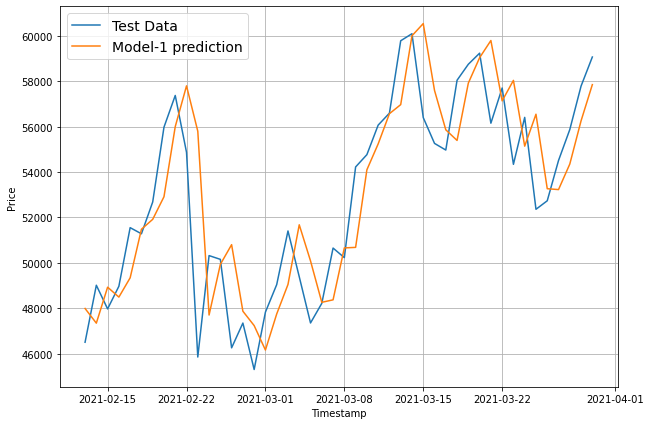

In [ ]:
# Plotting model-1 predictions
plt.figure(figsize=(10,7))
offset=400
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label='Test Data', format="-")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_prediction, start=offset, label="Model-1 prediction", format='-')

In [ ]:
# [:,0] means get every rows and get the zeroth dimenstion

In [ ]:
# Autoregressive data is the reason for our prediction coming after the actual value

### We can make a large horizon predictions (like a week prediction) and later use either mean metric or any other to make a one prediciton

In [ ]:
# Instead of prediction the exact prediction point, we can predict the prediction direction or prediction intervals like 99% prediction interval

In [ ]:
## Model-2: Dense (Windows:30, Horizon:1)
HORIZON=1
WINDOW_SIZE=30

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2206, 2206)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1764, 442, 1764, 442)

In [ ]:
train_windows[:3]

array([[754.9 , 784.19, 809.4 , 828.79, 905.  , 919.24, 785.  , 824.76,
        852.61, 896.59, 844.05, 823.  , 841.14, 814.4 , 797.2 , 842.07,
        826.02, 812.  , 780.  , 806.8 , 751.95, 788.  , 794.21, 799.99,
        803.  , 814.99, 782.33, 763.99, 705.01, 680.49],
       [784.19, 809.4 , 828.79, 905.  , 919.24, 785.  , 824.76, 852.61,
        896.59, 844.05, 823.  , 841.14, 814.4 , 797.2 , 842.07, 826.02,
        812.  , 780.  , 806.8 , 751.95, 788.  , 794.21, 799.99, 803.  ,
        814.99, 782.33, 763.99, 705.01, 680.49, 687.81],
       [809.4 , 828.79, 905.  , 919.24, 785.  , 824.76, 852.61, 896.59,
        844.05, 823.  , 841.14, 814.4 , 797.2 , 842.07, 826.02, 812.  ,
        780.  , 806.8 , 751.95, 788.  , 794.21, 799.99, 803.  , 814.99,
        782.33, 763.99, 705.01, 680.49, 687.81, 675.1 ]])

In [ ]:
len(prices)

2236

In [ ]:
tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="relu")
], name="model_2_dense")

model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
14/14 [==============================] - 1s 39ms/step - loss: 1372.0903 - val_loss: 5364.0171
Epoch 2/100
14/14 [==============================] - 0s 33ms/step - loss: 606.1740 - val_loss: 3543.7434
Epoch 3/100
14/14 [==============================] - 0s 33ms/step - loss: 471.9269 - val_loss: 1491.7014
Epoch 4/100
14/14 [==============================] - 0s 33ms/step - loss: 308.7610 - val_loss: 1227.4225
Epoch 5/100
14/14 [==============================] - 0s 33ms/step - loss: 250.7201 - val_loss: 1088.0968
Epoch 6/100
14/14 [==============================] - 0s 34ms/step - loss: 236.1304 - val_loss: 1040.8967
Epoch 7/100
14/14 [==============================] - 0s 33ms/step - loss: 233.5110 - val_loss: 945.2474
Epoch 8/100
14/14 [==============================] - 0s 4ms/step - loss: 233.6783 - val_loss: 1309.9822
Epoch 9/100
14/14 [==============================] - 0s 5ms/step - loss: 242.8118 - val_loss: 1110.1617
Epoch 10/100
14/14 [==============================] - 0s 

In [ ]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 604.2599


604.2598876953125

In [ ]:
model_2 = tf.keras.models.load_model("models/model_2_dense")
model_2.evaluate(test_windows, test_labels)

14/14 [==============================] - 1s 34ms/step - loss: 603.2613


603.2612915039062

In [ ]:
# Get the forecast predictions
model_2_prediction = make_prediction(model=model_2, input_data=test_windows)

In [ ]:
# Evaluate the results for model-2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_prediction)
model_2_results

{'mae': 603.2613,
 'mape': 2.9234288,
 'mase': 0.99878794,
 'mse': 1466505.4,
 'rmse': 1210.9935}

In [ ]:
model_1_results

{'mae': 562.756,
 'mape': 2.7844803,
 'mase': 0.9986764,
 'mse': 1333578.2,
 'rmse': 1154.8066}

In [ ]:
# Task is to make a for-loop and create a 30 different models with 1-30 window size and check which one performs best with the horizon of 1.

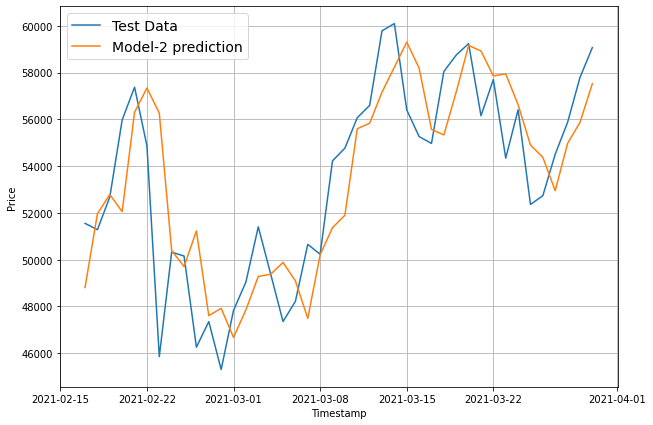

In [ ]:
offset=400
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_prediction, format="-", start=offset, label="Model-2 prediction")

## Model predictions are lagging the test data trend